In [6]:
# Libraries Imports
#-----------------------------------------------------------------------------------------------------
from configparser import ConfigParser
from sqlalchemy import create_engine
from datetime import datetime
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from datetime import date, timedelta
import plotly.express as px
import plotly.graph_objects as go

# Load connexion configuration file
#-----------------------------------------------------------------------------------------------------
config_filename = "./conf/GetWeather.ini"

# Read config.ini file
config_object = ConfigParser()
config_object.read(config_filename)
if  not config_object:
    print("Error while loading configuration !!!")

# Log initialization
cfg = config_object['INFO']
# Establish connection with DB (using sqlalchemy)
#-----------------------------------------------------------------------------------------------------
db_connection_str = "mysql+pymysql://{}:{}@{}/WeatherDB".format(cfg['user'],cfg['password'],cfg['host'])
db_connection = create_engine(db_connection_str)

In [6]:
# Count sorted number of records per locations
#-----------------------------------------------------------------------------------------------------
raw_data = pd.read_sql(
"""SELECT Locations.name as name, COUNT(*) as nbRecords
FROM RawRecords
INNER JOIN Locations ON RawRecords.id_location = Locations.id
GROUP BY id_location
ORDER BY nbRecords DESC;""", con=db_connection)
pdata = pd.DataFrame(raw_data)

# Display header just to be sure we have something
pdata.head(10)


,name,nbRecords
0,Hérémence,4379
1,Geneva,4208
2,Lausanne,4181
3,Sion,3863
4,Evolène,3327


In [ ]:
# Get average values on all records per locations
#-----------------------------------------------------------------------------------------------------
raw_data = pd.read_sql(
"""SELECT 
	    id_location, 
        Locations.name,
	    ROUND(AVG(pressure),2) AS avgPress,
	    ROUND(AVG(temp - 271.15),2) AS avgTemp,
	    ROUND(AVG(humidity),2) AS avgHumidity
    FROM Records
    INNER JOIN Locations on id_location = Locations.id
    GROUP BY id_location;""", con=db_connection)
pdata = pd.DataFrame(raw_data)

# Display header just to be sure we have something
pdata.head(10)


In [ ]:
# Get minimum values per locations
#-----------------------------------------------------------------------------------------------------
raw_data = pd.read_sql(
""" SELECT 
	    id_location, 
        Locations.name,
	    ROUND(MIN(pressure),2) AS MINPress,
	    ROUND(MIN(temp - 271.15),2) AS MINTemp,
	    ROUND(MIN(humidity),2) AS MINHumidity
    FROM Records
    Inner join Locations on id_location = Locations.id
    group by id_location;;""", con=db_connection)
pdata = pd.DataFrame(raw_data)

# Display header just to be sure we have something
pdata.head(10)

In [ ]:
# Hourly stats for a given day at a given location
#-----------------------------------------------------------------------------------------------------
my_date='2021-08-10'
loc = 6
raw_data = pd.read_sql(""" call Get_Hourly_Stats('{}',{});""".format(my_date, loc), con=db_connection)
pdata = pd.DataFrame(raw_data)

# Display header just to be sure we have something
pdata.head(30)

In [ ]:
# Get hourly stats for a given range of day(s) and a single location
#-----------------------------------------------------------------------------------------------------
def daterange(start_date, end_date):
    for n in range(int((end_date - start_date).days)):
        yield start_date + timedelta(n)

# work variables for aggregation
start_date = date(2021,1,1)
end_date = date(2022,1,1)
loc = 6
pdata = pd.DataFrame([])
flagFirstRec = True
iter = 0

for my_date in daterange(start_date, end_date):
    iter += 1
    query = "call Get_Hourly_Stats('{}',{});".format(my_date, loc)
    raw_data = pd.read_sql(query, con=db_connection)
   
    if flagFirstRec:
        pdata = pd.DataFrame(raw_data)
        flagFirstRec = False
    else:
        pdata = pdata.append(pd.DataFrame(raw_data))
    
print("{} aggregate(s) created for a period of {} day(s).".format(pdata.shape,iter))

In [ ]:
#pdata.insert(0, 'idx', range(0,len(pdata)))
pdata.reset_index(drop=True)

In [ ]:
my_date = '2021-08-23'
loc = 6
query = "call Get_Monthly_Stats('{}',{});".format(my_date, loc)

pdata = pd.read_sql(query, con=db_connection)
pdata.rename(columns = {'date_timestamp':'timestamp'}, inplace = True)
pdata.insert(0,'id',0)
pdata.head(5)



In [91]:
pdata.to_sql('RecordsByHour', con=db_connection, if_exists='append',
           index=False)

In [ ]:
# TimeZone tools to get if measures are UTC/CET
from pytz import all_timezones
for timezone in all_timezones:
    print(timezone)

In [7]:
# Daily stats
#-----------------------------------------------------------------------------------------------------
queryDate = datetime.today().strftime('%Y-%m-%d')
#queryDate = '2021-09-03'
location = 6
raw_data = pd.read_sql(
"""
SELECT Locations.name, date_timestamp, hour(date_timestamp) as hour, (temp-273.15) as temp, pressure,humidity, clouds_cover, rain_1h, snow_1h,wind_dir,wind_speed 
FROM RawRecords
INNER JOIN Locations ON RawRecords.id_location = Locations.id
WHERE RawRecords.date_timestamp >= '{}' AND  RawRecords.id_location = {}
GROUP BY HOUR(date_timestamp)
ORDER BY HOUR(date_timestamp)
""".format(queryDate, location), con=db_connection)
pdata = pd.DataFrame(raw_data)
pdata.head(100)


,name,date_timestamp,hour,temp,pressure,humidity,clouds_cover,rain_1h,snow_1h,wind_dir,wind_speed
0,Hérémence,2021-10-01 00:00:38,0,7.339990,1026.0,78.0,0,0.0,0.0,80,1.54
1,Hérémence,2021-10-01 01:00:08,1,7.240015,1026.0,79.0,0,0.0,0.0,50,1.03
2,Hérémence,2021-10-01 02:00:02,2,6.629999,1026.0,83.0,0,0.0,0.0,80,2.06
3,Hérémence,2021-10-01 03:00:02,3,6.600000,1026.0,83.0,0,0.0,0.0,100,1.54
4,Hérémence,2021-10-01 04:00:02,4,6.170007,1026.0,83.0,0,0.0,0.0,90,2.06
5,Hérémence,2021-10-01 05:00:02,5,6.040002,1025.0,87.0,0,0.0,0.0,70,2.57
6,Hérémence,2021-10-01 06:00:01,6,5.629999,1025.0,83.0,0,0.0,0.0,80,2.06
7,Hérémence,2021-10-01 07:00:02,7,5.969995,1025.0,81.0,0,0.0,0.0,70,2.57
8,Hérémence,2021-10-01 08:00:02,8,5.409998,1025.0,87.0,0,0.0,0.0,70,3.09
9,Hérémence,2021-10-01 09:00:02,9,8.740015,1024.0,75.0,20,0.0,0.0,126,2.02


In [ ]:
# Set plot size
plt.figure(figsize=(30, 16))

# draw temp curve with pyplot
plt.subplot(2, 2, 1)
xpoints = raw_data['hour'].tolist()
ypoints = raw_data['temp'].tolist()
plt.title("Temperature")
plt.xlabel("hours of the day")
plt.ylabel("Temperature")
plt.grid(axis = 'x',linestyle='--',linewidth=0.5)
display(plt.plot(xpoints, ypoints, 'o-r', linewidth=1.5))

# draw cloud cover percentage
plt.subplot(2, 2, 2)
ypoints = raw_data['clouds_cover'].tolist()
plt.title("Clouds")
plt.xlabel("hours of the day")
plt.ylabel("Clouds coverage")
plt.grid(axis = 'x',linestyle='--',linewidth=0.5)
#plt.plot(xpoints, ypoints, 'o-g', linewidth=1.5)
plt.bar(xpoints,ypoints)

# draw humidity cover percentage
plt.subplot(2, 2, 3)
ypoints = raw_data['humidity'].tolist()
plt.title("Humidity")
plt.xlabel("hours of the day")
plt.ylabel("relative Humidity")
plt.grid(axis = 'x',linestyle='--',linewidth=0.5)
plt.plot(xpoints, ypoints, 'o-b', linewidth=1.5)

# draw rain barchart
plt.subplot(2, 2, 4)
ypoints = raw_data['rain_1h'].tolist()
plt.title("Rain")
plt.xlabel("hours of the day")
plt.ylabel("rain")
plt.grid(axis = 'x',linestyle='--',linewidth=0.5)
plt.bar(xpoints,ypoints)
plt.show()
# Super title
plt.suptitle("Weather today")

# Show graphs
plt.show()



In [ ]:
import plotly.express as px
df = px.data.wind()
fig = px.bar_polar(df, r="frequency", theta="direction",
                   color="strength", template="plotly_dark",
                   color_discrete_sequence= px.colors.sequential.Plasma_r)
fig.show()


In [47]:
# df.tail(20)
# df[df['direction'] == 'N']
nt = np.NaN
nt = pd.DataFrame(raw_data['wind_speed'])
nt.insert(1,'wind_dir',raw_data['wind_dir'],allow_duplicates=True)
nt = nt.groupby('wind_dir')
s = nt['wind_dir'].agg([np.size])

In [48]:
for wd in s.index:
    print("{}".format(wd))



50
70
80
90
100
112
126


In [49]:
list = s['size']

for iter in list:
    print("{}".format(iter))


1
3
4
3
1
1
1


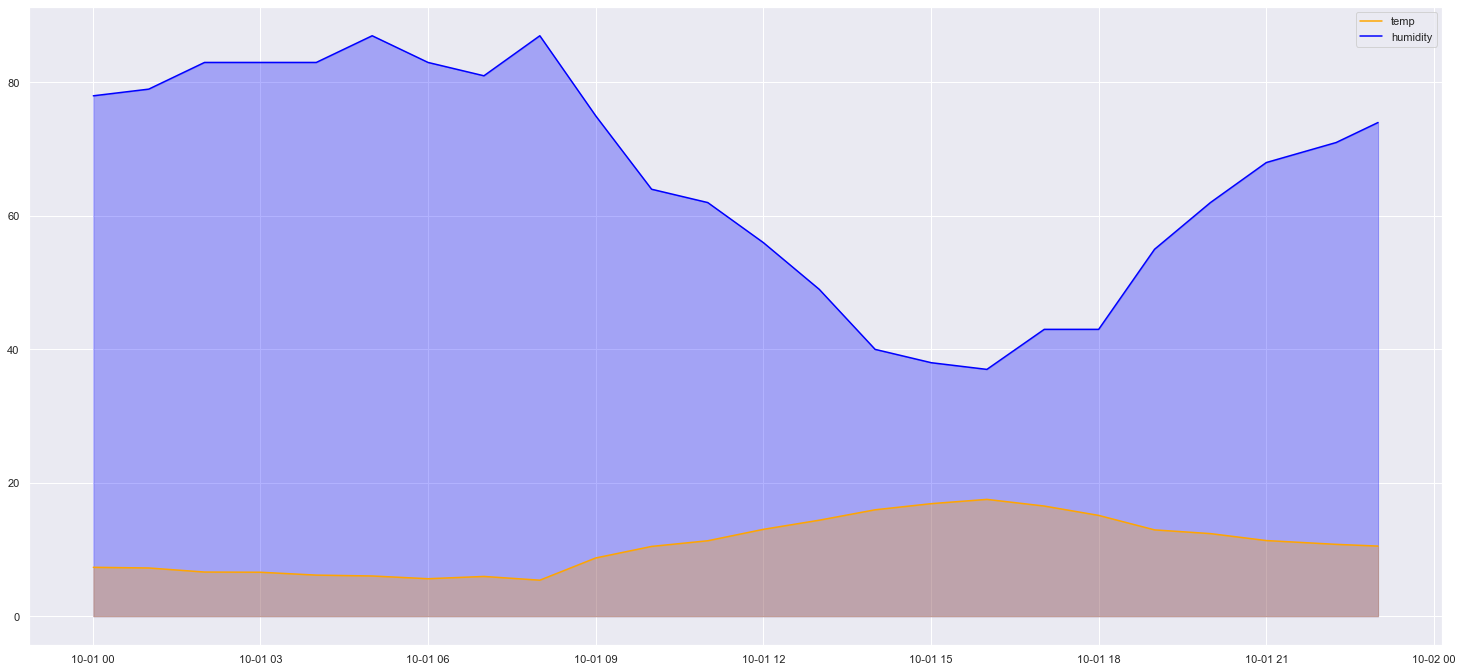

temperature min : 5.409997558593773 C°  max : 17.520013427734398 C° delta : 12.110015869140625 C°
humidity min    : 37.0 %   max : 87.0 %  delta : 50.0 %


In [8]:
import seaborn as sb
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = [20.50, 9.50]
plt.rcParams["figure.autolayout"] = True

sb.set()
sb.set_palette("PuBuGn_d")

fig, ax = plt.subplots()
ax.plot(raw_data['date_timestamp'], raw_data['temp'], label="temp", color='orange')
ax.plot(raw_data['date_timestamp'], raw_data['humidity'], label="humidity", color='blue')
ax.fill_between(raw_data['date_timestamp'], raw_data['humidity'], color='blue', alpha=0.3)
ax.fill_between(raw_data['date_timestamp'], raw_data['temp'], color='orange', alpha=0.3)
plt.legend()
plt.show()

print("temperature min : {} C°  max : {} C° delta : {} C°".format(raw_data['temp'].min(),raw_data['temp'].max(),raw_data['temp'].max() - raw_data['temp'].min()))
print("humidity min    : {} %   max : {} %  delta : {} %".format(raw_data['humidity'].min(),raw_data['humidity'].max(),raw_data['humidity'].max() - raw_data['humidity'].min()))

No handles with labels found to put in legend.


<Figure size 2304x1152 with 0 Axes>

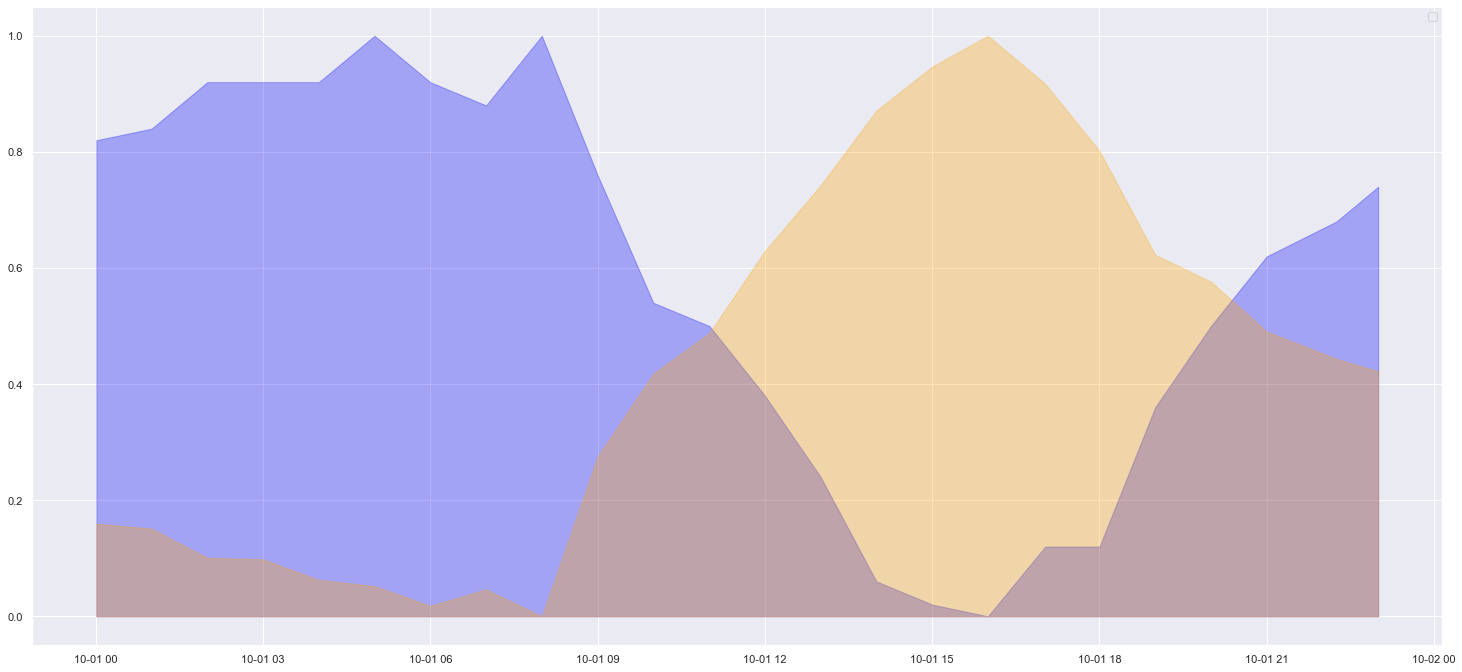

In [9]:
plt.figure(figsize=(32,16))
sb.set()
sb.set_palette("PuBuGn_d")

fig, ax = plt.subplots()

dt = (raw_data['temp'] - raw_data['temp'].min()) / (raw_data['temp'].max() - raw_data['temp'].min())
dh = (raw_data['humidity'] - raw_data['humidity'].min()) / (raw_data['humidity'].max() - raw_data['humidity'].min())
ax.fill_between(raw_data['date_timestamp'], dh, color='blue', alpha=0.3)
ax.fill_between(raw_data['date_timestamp'], dt, color='orange', alpha=0.3)
plt.legend()
plt.show()

<AxesSubplot:>

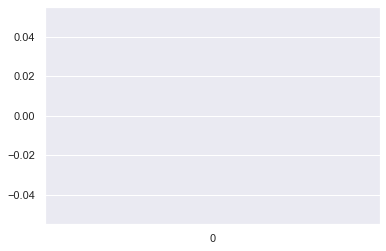

In [22]:
sb.barplot(data=raw_data['rain_1h'],label='rain')